In [2]:
# ========================
# ChemBERTa + MLP + K-Fold (With/Without SMOTE, Timed & Combined Visuals)
# ========================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE


In [3]:
# ----------------------------- Configuration -----------------------------
CHEMBERTA_MODEL_NAME = "DeepChem/ChemBERTa-77M-MLM"
TRAIN_FILE_PATH = 'market_approvability_train.csv'
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
NUM_FOLDS = 5
RANDOM_STATE = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("✅ Using device:", device)


# ----------------------------- Load Data -----------------------------
df_train = pd.read_csv(TRAIN_FILE_PATH)
smiles_train = df_train['smiles'].tolist()
labels_train = df_train['label'].tolist()


TEST_FILE_PATH = 'market_approvability_test.csv'

test_df = pd.read_csv(TEST_FILE_PATH)
smiles_test = test_df['smiles'].tolist()
labels_test = test_df['label'].values  # Adjust column name accordingly


✅ Using device: cuda


In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

# ----------------------------- Constants -----------------------------
BATCH_SIZE = 32
CHEMBERTA_MODEL_NAME = "DeepChem/ChemBERTa-77M-MLM"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------- Load ChemBERTa -----------------------------
tokenizer = AutoTokenizer.from_pretrained(CHEMBERTA_MODEL_NAME)
chemberta_model = AutoModel.from_pretrained(CHEMBERTA_MODEL_NAME).to(device).eval()

# ----------------------------- Embedding Function -----------------------------
def get_embeddings(smiles_list):
    embeddings = []
    chemberta_model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(smiles_list), BATCH_SIZE), desc="Generating Embeddings"):
            batch = smiles_list[i:i+BATCH_SIZE]
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            outputs = chemberta_model(input_ids=input_ids, attention_mask=attention_mask)
            pooled = outputs.last_hidden_state[:, 0, :]  # CLS token
            embeddings.append(pooled.cpu())
    return torch.cat(embeddings, dim=0).detach()

# ----------------------------- Load Data -----------------------------
TRAIN_FILE_PATH = "market_approvability_train.csv"
TEST_FILE_PATH = "market_approvability_test.csv"

df_train = pd.read_csv(TRAIN_FILE_PATH)
smiles_train = df_train['smiles'].tolist()
labels_train = df_train['label'].tolist()

test_df = pd.read_csv(TEST_FILE_PATH)
smiles_test = test_df['smiles'].tolist()
labels_test = test_df['label'].values

# ----------------------------- Generate Embeddings -----------------------------
train_embeddings = get_embeddings(smiles_train).to(device)
y_array = np.array(labels_train)

test_embeddings = get_embeddings(smiles_test).to(device)
y_test = np.array(labels_test)


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating Embeddings: 100%|██████████| 30/30 [00:00<00:00, 181.82it/s]


In [5]:
#PK edit

import time
import torch

def get_embeddings(smiles_list):
    embeddings = []

    start_time = time.time()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    for i in tqdm(range(0, len(smiles_list), BATCH_SIZE), desc="Generating Embeddings"):
        batch = smiles_list[i:i+BATCH_SIZE]
        encoded = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = chemberta_model(input_ids=input_ids, attention_mask=attention_mask)
            pooled = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(pooled.cpu())

    end_time = time.time()
    total_time = end_time - start_time

    print(f"\n Embedding generation completed in {total_time:.2f} seconds.")

    if torch.cuda.is_available():
        peak_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 3)  # GB
        print(f" Peak GPU memory used: {peak_memory:.2f} GB")

    return torch.cat(embeddings, dim=0).detach()


# # ----------------------------- Extract Embeddings -----------------------------
# def get_embeddings(smiles_list):
#     embeddings = []
#     for i in tqdm(range(0, len(smiles_list), BATCH_SIZE), desc="Generating Embeddings"):
#         batch = smiles_list[i:i+BATCH_SIZE]
#         encoded = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
#         input_ids = encoded['input_ids'].to(device)
#         attention_mask = encoded['attention_mask'].to(device)

#         with torch.no_grad():
#             outputs = chemberta_model(input_ids=input_ids, attention_mask=attention_mask)
#             pooled = outputs.last_hidden_state.mean(dim=1)
#             embeddings.append(pooled.cpu())

#     return torch.cat(embeddings, dim=0).detach()

train_embeddings = get_embeddings(smiles_train).to(device)
y_array = np.array(labels_train)


test_embeddings = get_embeddings(smiles_test).to(device)  # tensor on same device as model
labels_test = np.array(labels_test)

Generating Embeddings: 100%|██████████| 264/264 [00:01<00:00, 177.35it/s]



 Embedding generation completed in 1.49 seconds.
 Peak GPU memory used: 0.09 GB


Generating Embeddings: 100%|██████████| 30/30 [00:00<00:00, 182.93it/s]


 Embedding generation completed in 0.17 seconds.
 Peak GPU memory used: 0.09 GB


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, classification_report
)

# ----------------------------- MLP Classifier -----------------------------
class ShallowMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x).view(-1)


# ----------------------------------------
# Evaluate model and collect per-class metrics + ROC/PR curves
# ----------------------------------------
def evaluate_model_with_report(model, loader):
    model.eval()
    all_probs, all_preds, all_tgts = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            probs = model(xb).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_tgts.extend(yb.cpu().numpy())

    y_true = np.array(all_tgts)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Generate detailed classification report (dict)
    report = classification_report(y_true, y_pred, output_dict=True)

    return report, y_true, y_prob


## PK EDITS : K CROSS VALIDATIONS
###
#Define standard scaler helper

def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    a = a[~np.isnan(a)]  # Remove NaNs
    if len(a) == 0:
        return np.nan, np.nan
    mean = np.mean(a)
    sem = np.std(a, ddof=1) / np.sqrt(len(a))
    h = sem * 1.96
    return mean, h

def analyze_results(fold_metrics, metric='f1-score', cls='0'):
    scores = [fold[cls][metric] for fold in fold_metrics if cls in fold and metric in fold[cls]]
    mean, ci95 = mean_confidence_interval(scores)
    print(f"{metric.upper()} (Class {cls}): {mean:.4f} ± {ci95:.4f}")
    return scores

def plot_roc_curves(curve_data, cls=1, title='ROC Curve'):
    plt.figure(figsize=(8, 6))
    for i, entry in enumerate(curve_data):
        if entry['class'] == cls:
            plt.plot(entry['fpr'], entry['tpr'], label=f"Fold {i+1}")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f"{title} (Class {cls})")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# Main K-Fold CV with optional per-fold ROC
# ----------------------------------------



In [7]:
def kfold_cv_with_external_test_and_ci(X, y, input_dim,
                                       test_embeddings, test_labels,
                                       use_smote=False, num_folds=5,
                                       batch_size= 64, num_epochs=30,
                                       learning_rate=0.001,
                                       verbose=True,
                                       return_fold_roc=False):


    
    def mean_confidence_interval(data, confidence=0.95):
        a = np.array(data)
        a = a[~np.isnan(a)]
        n = len(a)
        if n == 0:
            return np.nan, np.nan
        mean = np.mean(a)
        se = np.std(a, ddof=1) / np.sqrt(n)
        h = se * 1.96  # 95% CI approx
        return mean, h

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    all_test_reports = []
    all_test_y_true = []
    all_test_y_prob = []
    fold_roc_data = []

    total_start = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        if verbose:
            print(f"\n--- Fold {fold}/{num_folds} ---")

        X_train = X[train_idx].cpu().numpy()
        y_train = np.array(y)[train_idx]
        X_val = X[val_idx].cpu().numpy()
        y_val = np.array(y)[val_idx]

        if use_smote:
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
            if verbose:
                print(f"SMOTE applied: train samples after resampling = {len(X_train)}")

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        test_scaled = scaler.transform(test_embeddings.cpu().numpy())

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
        test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)
        test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).to(device)

        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(TensorDataset(test_tensor, test_labels_tensor), batch_size=batch_size, shuffle=False)

        model = ShallowMLP(input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        # Train model
        model.train()
        for epoch in range(num_epochs):
            losses = []
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = model(xb).squeeze()
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses):.4f}")

        # Evaluate on external test set
        model.eval()
        all_probs = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for xb, yb in test_loader:
                probs = model(xb).squeeze()
                preds = (probs >= 0.5).long()
                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(yb.cpu().numpy())

        y_true_fold = np.array(all_targets)
        y_pred_fold = np.array(all_preds)
        y_prob_fold = np.array(all_probs)

        report = classification_report(y_true_fold, y_pred_fold, output_dict=True)
        print(f"\nTest classification report for fold {fold}:\n")
        print(classification_report(y_true_fold, y_pred_fold))

        all_test_reports.append(report)
        all_test_y_true.append(y_true_fold)
        all_test_y_prob.append(y_prob_fold)

        if return_fold_roc:
            fpr, tpr, _ = roc_curve(y_true_fold, y_prob_fold)
            fold_roc_data.append({'class': 1, 'fpr': fpr, 'tpr': tpr})

    total_time = time.time() - total_start
    print(f"\nTotal k-fold training + test evaluation time: {total_time:.2f} seconds")

    # Aggregate metrics across folds for test set
    metric_keys = ['precision', 'recall', 'f1-score', 'support']
    aggregated_metrics = defaultdict(lambda: defaultdict(list))
    accuracies = []

    for report in all_test_reports:
        for cls_or_avg, metrics in report.items():
            if isinstance(metrics, dict):
                for metric_key in metric_keys:
                    if metric_key in metrics:
                        aggregated_metrics[cls_or_avg][metric_key].append(metrics[metric_key])
        if 'accuracy' in report:
            accuracies.append(report['accuracy'])

    print("\nAggregated TEST metrics across folds:\n")
    for cls_or_avg in aggregated_metrics.keys():
        print(f"Class/Average: {cls_or_avg}")
        for metric_key in metric_keys:
            vals = aggregated_metrics[cls_or_avg][metric_key]
            mean, ci95 = mean_confidence_interval(vals)
            print(f"  {metric_key}: {mean:.4f} ± {ci95:.4f}")
        print()

    if accuracies:
        mean_acc, ci95_acc = mean_confidence_interval(accuracies)
        print(f"Overall TEST Accuracy: {mean_acc:.4f} ± {ci95_acc:.4f}")

    # Aggregated ROC for test set (all folds combined)
    y_true_agg = np.concatenate(all_test_y_true)
    y_prob_agg = np.concatenate(all_test_y_prob)
    fpr, tpr, _ = roc_curve(y_true_agg, y_prob_agg)
    auc_score = roc_auc_score(y_true_agg, y_prob_agg)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Aggregated TEST ROC (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Aggregated ROC Curve Across All Folds (TEST SET)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return all_test_reports, (y_true_agg, y_prob_agg), fold_roc_data if return_fold_roc else all_test_reports


### Without SMOTE

WITHOUT SMOTE:

--- Fold 1/5 ---
Epoch 1/30, Loss: 0.5997
Epoch 2/30, Loss: 0.5379
Epoch 3/30, Loss: 0.5008
Epoch 4/30, Loss: 0.4622
Epoch 5/30, Loss: 0.4302
Epoch 6/30, Loss: 0.3956
Epoch 7/30, Loss: 0.3615
Epoch 8/30, Loss: 0.3415
Epoch 9/30, Loss: 0.3135
Epoch 10/30, Loss: 0.2895
Epoch 11/30, Loss: 0.2699
Epoch 12/30, Loss: 0.2550
Epoch 13/30, Loss: 0.2339
Epoch 14/30, Loss: 0.2259
Epoch 15/30, Loss: 0.2147
Epoch 16/30, Loss: 0.1937
Epoch 17/30, Loss: 0.1876
Epoch 18/30, Loss: 0.1724
Epoch 19/30, Loss: 0.1705
Epoch 20/30, Loss: 0.1542
Epoch 21/30, Loss: 0.1540
Epoch 22/30, Loss: 0.1474
Epoch 23/30, Loss: 0.1421
Epoch 24/30, Loss: 0.1288
Epoch 25/30, Loss: 0.1221
Epoch 26/30, Loss: 0.1253
Epoch 27/30, Loss: 0.1092
Epoch 28/30, Loss: 0.1123
Epoch 29/30, Loss: 0.1002
Epoch 30/30, Loss: 0.1059

Test classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73       381
         1.0       0.80      0.87      0.84   

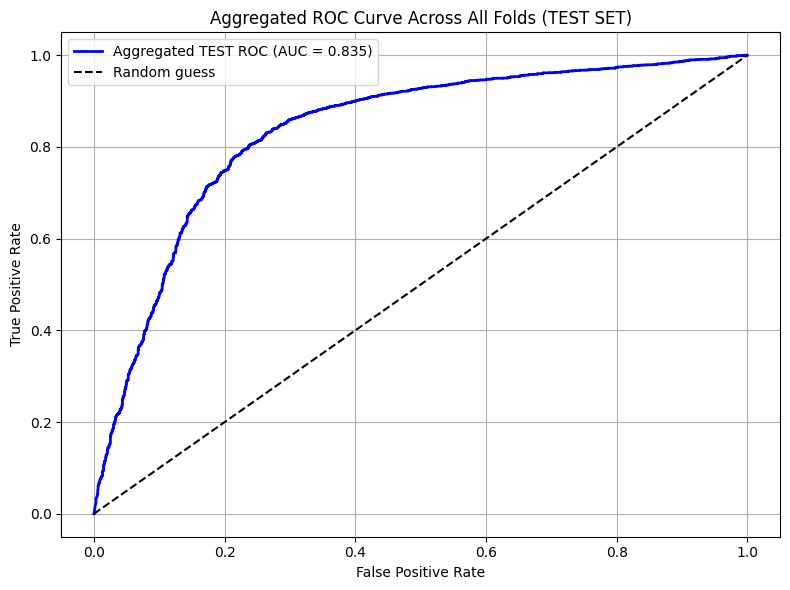

In [8]:
print('WITHOUT SMOTE:')
results_no_smote = kfold_cv_with_external_test_and_ci(train_embeddings, y_array, 
                                                             train_embeddings.shape[1], 
                                                             test_embeddings, labels_test
                                                            )

### With SMOTE

WITH SMOTE:

--- Fold 1/5 ---


C:\Users\berna\anaconda3\envs\cuda_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\berna\anaconda3\envs\cuda_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\berna\anaconda3\envs\cuda_env\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\berna\anaconda3\envs\cuda_env\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\berna\anaconda3\envs\cuda_env\Lib\subprocess.py",

SMOTE applied: train samples after resampling = 8236
Epoch 1/30, Loss: 0.5968
Epoch 2/30, Loss: 0.5183
Epoch 3/30, Loss: 0.4604
Epoch 4/30, Loss: 0.4143
Epoch 5/30, Loss: 0.3777
Epoch 6/30, Loss: 0.3365
Epoch 7/30, Loss: 0.3115
Epoch 8/30, Loss: 0.2794
Epoch 9/30, Loss: 0.2588
Epoch 10/30, Loss: 0.2344
Epoch 11/30, Loss: 0.2152
Epoch 12/30, Loss: 0.2067
Epoch 13/30, Loss: 0.1889
Epoch 14/30, Loss: 0.1747
Epoch 15/30, Loss: 0.1569
Epoch 16/30, Loss: 0.1559
Epoch 17/30, Loss: 0.1465
Epoch 18/30, Loss: 0.1392
Epoch 19/30, Loss: 0.1315
Epoch 20/30, Loss: 0.1271
Epoch 21/30, Loss: 0.1202
Epoch 22/30, Loss: 0.1082
Epoch 23/30, Loss: 0.1149
Epoch 24/30, Loss: 0.1101
Epoch 25/30, Loss: 0.1007
Epoch 26/30, Loss: 0.1033
Epoch 27/30, Loss: 0.0874
Epoch 28/30, Loss: 0.0894
Epoch 29/30, Loss: 0.0978
Epoch 30/30, Loss: 0.0820

Test classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78       381
         1.0       0.84   

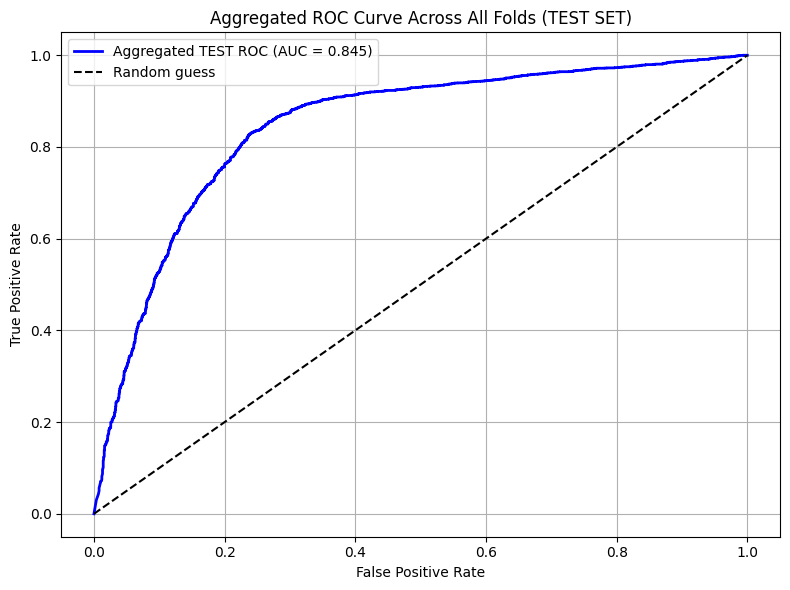

In [9]:
print('WITH SMOTE:')
results_no_smote = kfold_cv_with_external_test_and_ci(train_embeddings, y_array, train_embeddings.shape[1], 
                                                             test_embeddings, labels_test, use_smote=True)